# Detecting Ads on Web Pages


![Credits : Limeproxies](https://limeproxies.com/blog/wp-content/uploads/2019/08/Ad-fraud-detection.jpg)

With almost every web page on the internet being flooded with advertisements, and with several of these advertisements being fraudulent or malicious links, it has become vital to be able to distinguish and further classify these advertisements in depth based on category of advertisements, wheather an advertisement is legitimate or fraudulent, and also its behaviour. 

The work in this notebook, is a first step towards being able to detect advertisements to begin with. I believe further work in this area, using intelligent semi-supervised clustering and classification techniques with neural nets would be the next step.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import gc
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

![](https://archive.ics.uci.edu/ml/assets/MLimages/Large51.jpg)

The dataset has been provided by the **UCI Machine Learning Repository**. As per the data description provided, given below are some notable interesting points regarding the dataset :
* The last column in every instance provides a label for the instance
* The first 3 columns (continuous attributes) provide the height, width and aspect ratio for the ad frame
* -28% data is missing for each continuous attribute
* Column number 3 to 1557 are u.r.l+term(n)
* Number of Instances: 3279
* Number of Attributes: 1558
* The features encode the geometry of the image (if available) as well as phrases occuring in the URL, the image's URL and alt text, the anchor text, and words occuring near the anchor text

In [2]:
#More meaningful column names
col_three = ["Height","Width","AspectRatio"]
col_attr = ["Attr"+str(i) for i in range(1,1556)]
names = col_three+col_attr+["label"]


#Dropping the first column which is simple meant as an index
#Dropping first row containing default column names as custom column names are used

init_df = pd.read_csv("add.csv",names= names,skiprows=1,index_col=0)


C:\Users\Viraj\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
init_df.head()

,Height,Width,AspectRatio,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,...,Attr1547,Attr1548,Attr1549,Attr1550,Attr1551,Attr1552,Attr1553,Attr1554,Attr1555,label
0,125,125,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
1,57,468,8.2105,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
2,33,230,6.9696,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
3,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
4,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.


In [4]:
init_df.isnull().sum()

Height         0
Width          0
AspectRatio    0
Attr1          0
Attr2          0
              ..
Attr1552       0
Attr1553       0
Attr1554       0
Attr1555       0
label          0
Length: 1559, dtype: int64

Looking at the null values in the columns, seems like Attr also has a couple null values. This will also need to be given attention during the data imputation process.

In [5]:
#subset of dataframe with Height, Width and Aspect Ratio columns for purpose of analysis
dim_df = init_df.iloc[:,:3]
dim_df.describe(include="all")
dim_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3279 entries, 0 to 3278
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Height       3279 non-null   object
 1   Width        3279 non-null   object
 2   AspectRatio  3279 non-null   object
dtypes: object(3)
memory usage: 102.5+ KB


In [6]:
dim_df.sort_values(by=["Height"])

,Height,Width,AspectRatio
1323,?,?,?
2118,?,?,?
1059,?,?,?
619,?,?,?
1621,?,?,?
...,...,...,...
1810,99,437,4.4141
733,99,144,1.4545
1985,99,150,1.5151
1435,99,101,1.0202


Seems like the null values in this dataset are represented by **"\s*\?\s*"** *(in terms of regex)*. Therefore these missing values need to be first converted to **NaN**. Followed by converting datatypes of these attributes to numeric. 
Post that, a good strategy to deal with the missing values needs to be found, relevant to the given use case.

In [7]:
dim_df = dim_df.replace("\?",np.NaN,regex=True).astype("float64")
dim_df[(dim_df.Height.isnull()) & (dim_df.Width.notnull())]



,Height,Width,AspectRatio
811,NaN,50.0,NaN
905,NaN,42.0,NaN
918,NaN,75.0,NaN
1053,NaN,70.0,NaN
1124,NaN,200.0,NaN
2171,NaN,72.0,NaN
2196,NaN,72.0,NaN
3051,NaN,67.0,NaN
3176,NaN,160.0,NaN


In [8]:
#Applying the above processing to the initial dataframe as well
init_df = init_df.replace("\?",np.NaN,regex=True)
init_df[["Height","Width","AspectRatio"]] = init_df[["Height","Width","AspectRatio"]].astype("float64") 
init_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3279 entries, 0 to 3278
Columns: 1559 entries, Height to label
dtypes: float64(3), int64(1554), object(2)
memory usage: 39.0+ MB


In [9]:
init_df.loc[:,"Height":"AspectRatio"]

,Height,Width,AspectRatio
0,125.0,125.0,1.0000
1,57.0,468.0,8.2105
2,33.0,230.0,6.9696
3,60.0,468.0,7.8000
4,60.0,468.0,7.8000
...,...,...,...
3274,170.0,94.0,0.5529
3275,101.0,140.0,1.3861
3276,23.0,120.0,5.2173
3277,NaN,NaN,NaN


In [10]:
init_df.label = init_df.label.apply(lambda x : 0 if "nonad." in x else 1)


In [11]:
init_df[init_df.label == 1]

,Height,Width,AspectRatio,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,...,Attr1547,Attr1548,Attr1549,Attr1550,Attr1551,Attr1552,Attr1553,Attr1554,Attr1555,label
0,125.0,125.0,1.0000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,57.0,468.0,8.2105,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,33.0,230.0,6.9696,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,60.0,468.0,7.8000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,60.0,468.0,7.8000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454,NaN,NaN,NaN,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
455,50.0,150.0,3.0000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
456,60.0,468.0,7.8000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
457,40.0,400.0,10.0000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Creating a matrix and a heatmap for the three attributes to see a pattern between the values

In [12]:
dim_df[(dim_df.Height.notnull()) & (dim_df.Width.isnull())]

,Height,Width,AspectRatio
486,15.0,NaN,NaN
569,100.0,NaN,NaN
587,100.0,NaN,NaN
885,237.0,NaN,NaN
1024,100.0,NaN,NaN
1028,100.0,NaN,NaN
1064,100.0,NaN,NaN


In [13]:
dim_df[(dim_df.Height.notnull()) & (dim_df.Width.notnull()) & (dim_df.AspectRatio.isnull())]

,Height,Width,AspectRatio


In [14]:
dim_df[(dim_df.Height.isnull()) & (dim_df.Width.isnull()) & (dim_df.AspectRatio.isnull())]

,Height,Width,AspectRatio
10,NaN,NaN,NaN
24,NaN,NaN,NaN
62,NaN,NaN,NaN
63,NaN,NaN,NaN
64,NaN,NaN,NaN
...,...,...,...
3261,NaN,NaN,NaN
3269,NaN,NaN,NaN
3270,NaN,NaN,NaN
3271,NaN,NaN,NaN


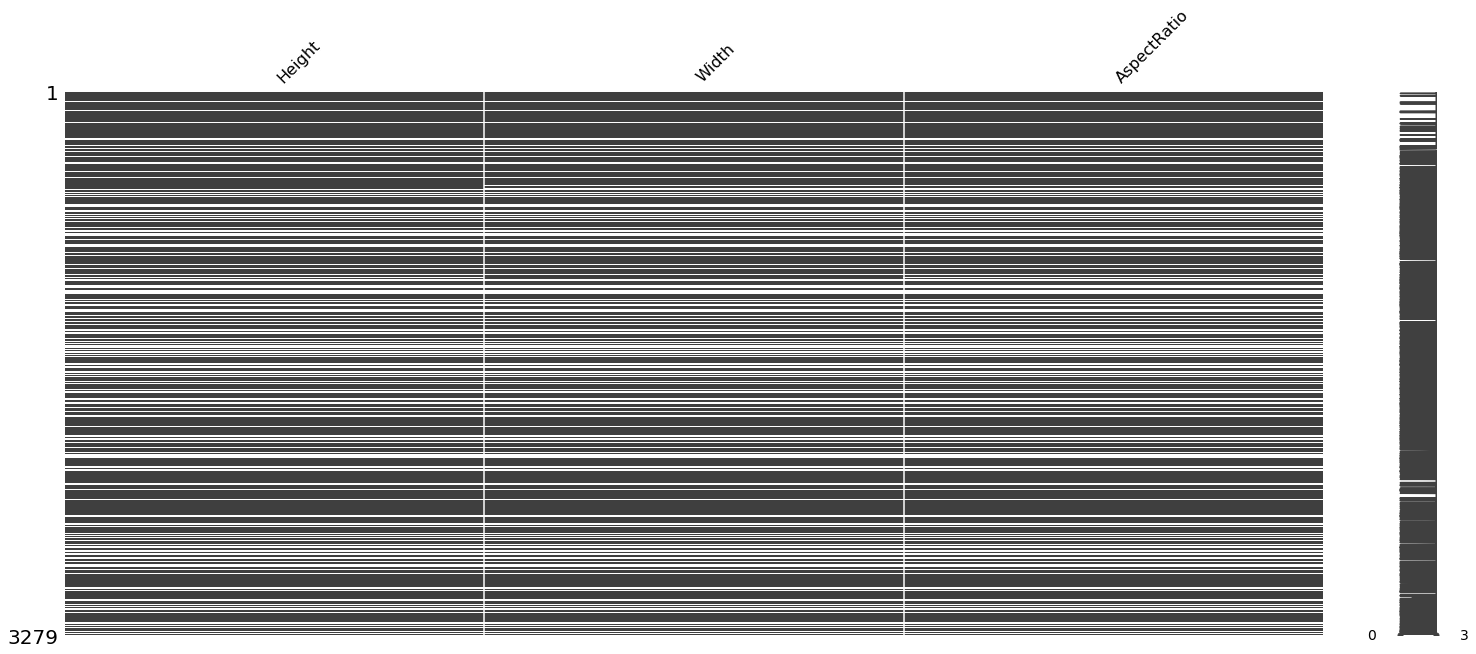

In [15]:
msno.matrix(dim_df)

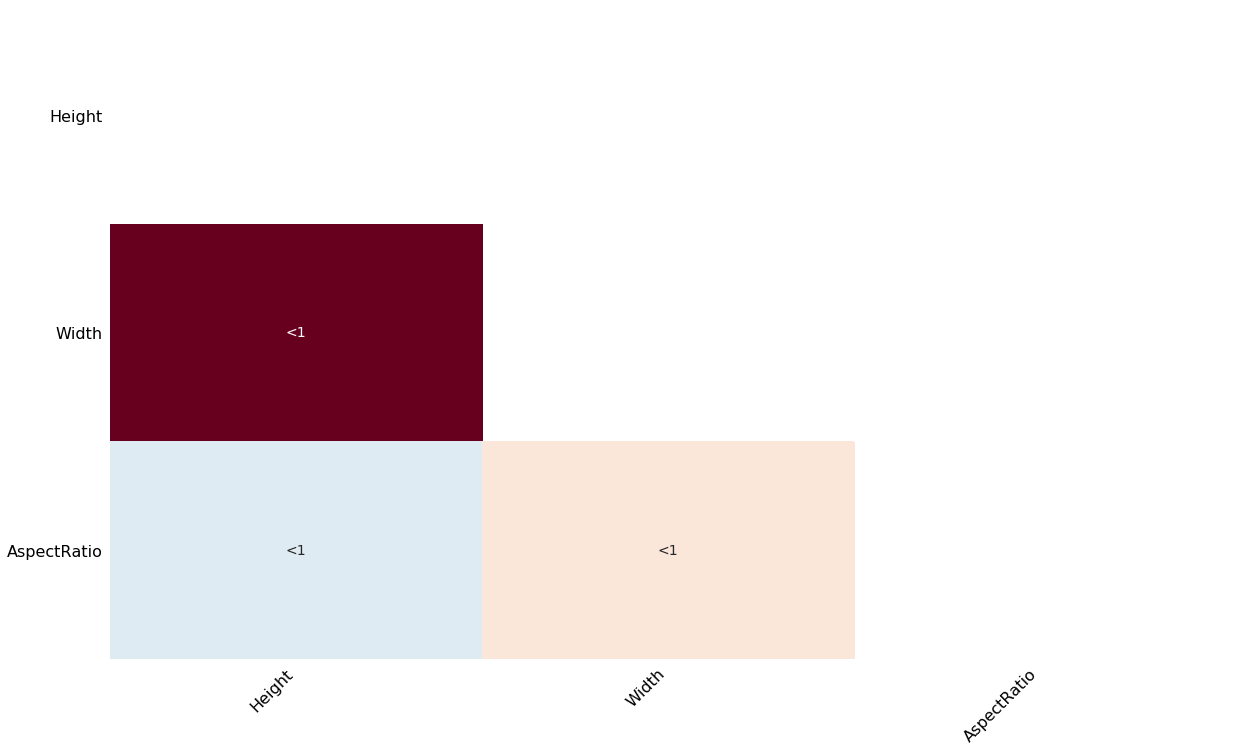

In [16]:
msno.heatmap(dim_df)

Visualising the distribution on individual columns might help in understanding the relationship between the missing values

15

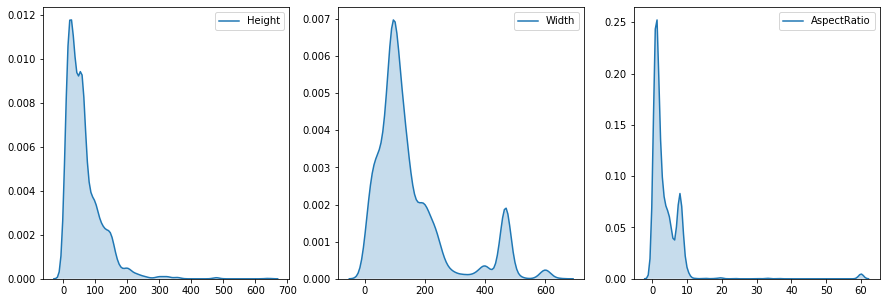

In [17]:
fig1 = plt.figure(figsize = (15,5))
ax1 = plt.subplot(1,3,1)
sns.kdeplot(dim_df.Height,shade=True)
ax2 = plt.subplot(1,3,2)
sns.kdeplot(dim_df.Width,shade=True)
ax3 = plt.subplot(1,3,3)
sns.kdeplot(dim_df.AspectRatio,shade=True)

del dim_df
gc.collect()

***Note***: As the first three columuns have a lot of missing values, (28% of the total number of instances that have no value for Height, Width or Aspect Ratio) we might want to try two strategies with this datasets and then compare their model performance at a later stage.

**The Approaches are as follows :** 
1. Drop records with only NaN values for all three attributes. Use regression or MICE (Multiple Imputation by Chained Equations) to fill in the remainder of the values for Height or Width. Calculate the value for aspect Ratio as (Width/Height)
2. Use MICE to complete the entire dataset (High probability of Erronous values as 25% of the values will be predicted/generated).  

In [18]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import RFE

class ImputeMissing(BaseEstimator, TransformerMixin):
    """ Transformer to select first 4 columns from the given dataframe
    to perform data imputation """
    
    def __init__(self):
        pass

        
    def fit(self, df, y=None):
        self.imputer = IterativeImputer(max_iter = 10, random_state = 3, sample_posterior = True)
        self.imputer.fit(df.loc[:,"Height":"Attr300"])
        return self
        
    
    def transform(self, df):
        result = self.imputer.transform(df.loc[:,"Height":"Attr300"])
        df.loc[:,"Height":"Attr300"] = result
        return df.loc[:,"Height":"AspectRatio"]
        
        
class RecallFeatures(BaseEstimator, TransformerMixin):
    """ Transformer to select all columns from the given dataframe
    except for the first three to join after performing standard scaling"""
    
    def __init__(self):
        pass
    
    def fit(self, df, y=None):
        return self
    
    def transform(self, df):
        return df.loc[:,"Attr1":].astype("bool")
    



In [19]:

preproc_f3 = Pipeline([("imputer",ImputeMissing()),("standard",StandardScaler())])

preproc_r = Pipeline([("recall", RecallFeatures())])

allfeatures = FeatureUnion([("firstThree",preproc_f3),("others",preproc_r)])

preproc_fin = Pipeline([("allfeats",allfeatures)])


## Approach 1 : Dropping rows with NaN for Height,Width, Aspect Ratio

The data needs to be split into training set and test set before imputing the data to avoid data leakage. By applying MICE to the entire dataset together, might lead to usage of certain knowledge regarding the test data set to impute values in the training set and vice versa.

In [20]:
appr1 = init_df.dropna(thresh=1557)
appr1.sort_values(by="Height", na_position="first")



Xtrain, Xtest, Ytrain, Ytest = train_test_split(appr1.iloc[:,:-1],appr1.iloc[:,-1],test_size = 0.2,random_state=3)


del appr1
gc.collect()

0

In [21]:
Xtrain.loc[:,"Height":"Attr1000"].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1908 entries, 2230 to 2620
Columns: 1003 entries, Height to Attr1000
dtypes: float64(3), int64(999), object(1)
memory usage: 14.6+ MB


Both the approaches will require a process of feature selection and normalization of the features due the the variability in the feature value range. i.e. Height, Width and Aspect Ratio have Integer values ranging from 0-10^3 whereas the values for the rest of the 1555 attributes are in (0,1).
However, this would contriobute towards enhancing model performance. Therefore, prior to that, we can first evaluate the performance of various types of model in turns via KFoldValidation and complete the process of model selection.

In [ ]:
models = []
models.append(("SVM : ",SVC()))
models.append(("NB : ",GaussianNB()))
models.append(("DT : ",DecisionTreeClassifier()))
models.append(("KNN : ",KNeighborsClassifier()))
models.append(("RF : ",RandomForestClassifier()))

seed = 7
results = []
names = []

for name,model in models:
    kfold = model_selection.KFold(n_splits=10,random_state=seed, shuffle=True)
    cv_results = model_selection.cross_val_score(model,Xtrain,Ytrain,cv=kfold,scoring="accuracy")
    results.append(cv_results)
    names.append(name)
    msg = "{} : {} ({})".format(name,cv_results.mean(),cv_results.std())
    print(msg)


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py", line 162, in fit
    accept_large_sparse=False)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py", line 73, in inner_f
    return f(**kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py", line 803, in check_X_y
    estimator=estimator)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py", line 73, i

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py", line 162, in fit
    accept_large_sparse=False)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py", line 73, in inner_f
    return f(**kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py", line 803, in check_X_y
    estimator=estimator)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py", line 73, i

SVM :  : nan (nan)


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/naive_bayes.py", line 210, in fit
    X, y = self._validate_data(X, y)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py", line 73, in inner_f
    return f(**kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py", line 803, in check_X_y
    estimator=estimator)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py", li

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/naive_bayes.py", line 210, in fit
    X, y = self._validate_data(X, y)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py", line 73, in inner_f
    return f(**kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py", line 803, in check_X_y
    estimator=estimator)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py", li

NB :  : nan (nan)


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 894, in fit
    X_idx_sorted=X_idx_sorted)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 158, in fit
    check_y_params))
  File "/opt/conda/lib/python3.7/site-packages/sklearn/base.py", line 429, in _validate_data
    X = check_array(X, **check_X_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py", line 73, in inner_f
    return f(**kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py", line 646, in check_ar

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 894, in fit
    X_idx_sorted=X_idx_sorted)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 158, in fit
    check_y_params))
  File "/opt/conda/lib/python3.7/site-packages/sklearn/base.py", line 429, in _validate_data
    X = check_array(X, **check_X_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py", line 73, in inner_f
    return f(**kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py", line 646, in check_ar

DT :  : nan (nan)


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/neighbors/_base.py", line 1132, in fit
    multi_output=True)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py", line 73, in inner_f
    return f(**kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py", line 803, in check_X_y
    estimator=estimator)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py", line 73, in

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/neighbors/_base.py", line 1132, in fit
    multi_output=True)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py", line 73, in inner_f
    return f(**kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py", line 803, in check_X_y
    estimator=estimator)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py", line 73, in

KNN :  : nan (nan)


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 304, in fit
    accept_sparse="csc", dtype=DTYPE)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py", line 73, in inner_f
    return f(**kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py", line 803, in check_X_y
    estimator=estimator)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.p

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 304, in fit
    accept_sparse="csc", dtype=DTYPE)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py", line 73, in inner_f
    return f(**kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py", line 803, in check_X_y
    estimator=estimator)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.p

As can be seen in the result of the above cross validation process for 5 different models on the valdiation data, a tree based classifier seems to be a better performer in this case.
Moving ahead, as we proceed to build a Random Forest model for the given dataset, do note that way Random Forests are built is invariant to monotonic transformations of the independent variables. Splits will be completely analogous and therefore we cannot expect to see a significant improvement in the model performce by using other means to achieve Normalized and Standardized features.

Also, as the dataset currently has over a thousand features, one area that shall be of importance is to have a look as the feature imporantce for the Random forest model.

In [77]:
print('Training Features Shape:', Xtrain.shape)
print('Training Labels Shape:', Ytrain.shape)
print('Testing Features Shape:', Xtest.shape)
print('Testing Labels Shape:', Ytest.shape)

Training Features Shape: (1908, 1558)
Training Labels Shape: (1908,)
Testing Features Shape: (477, 1558)
Testing Labels Shape: (477,)


imp = IterativeImputer(max_iter = 10, random_state = 3, sample_posterior = True)
imp.fit(Xtrain.loc[:,"Height":"Attr300"])
res = imp.transform(Xtrain.loc[:,"Height":"Attr300"])

In [23]:
from sklearn.feature_selection import RFE

estimator = RandomForestClassifier(n_estimators = 10000, max_features = 'sqrt', random_state = 3)
selector = RFE(estimator, n_features_to_select = 565, step=0.1)

In [78]:
from sklearn.feature_selection import RFE

estimator = RandomForestClassifier(n_estimators = 10000, max_features = 'sqrt', random_state = 3)
selector = RFE(estimator, n_features_to_select = 565, step=0.1)

pipeline = Pipeline([("preprocessing",preproc_fin),("selectPredict",selector)])

pipeline.fit_transform(Xtrain,Ytrain)

array([[-0.90677828, -0.57709331,  0.20856569, ...,  0.        ,
         0.        ,  0.        ],
       [-0.06637743,  2.38940271,  0.59082099, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.12037831, -0.65354939, -0.46294966, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.96280501, -0.41653553,  0.6863732 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.43988892, -0.88291764, -0.46294966, ...,  0.        ,
         0.        ,  0.        ],
       [-0.4585645 , -0.42418114, -0.22056692, ...,  0.        ,
         0.        ,  0.        ]])

In [79]:
pipeline.transform(Xtrain).shape

(1908, 565)

Xtrain.loc[:,"Height":"Attr300"] = res

In [80]:
preds = pipeline.predict(Xtest)
np.mean(preds == Ytest)


0.9727463312368972

We shall use more detailed evaluation methods for our classification model for a more robust check on model performance

In [81]:
accuracy_score(preds,Ytest)

0.9727463312368972

In [82]:
classification_report(preds,Ytest)

'              precision    recall  f1-score   support\n\n           0       0.99      0.98      0.98       399\n           1       0.90      0.94      0.92        78\n\n    accuracy                           0.97       477\n   macro avg       0.94      0.96      0.95       477\nweighted avg       0.97      0.97      0.97       477\n'

In [83]:
confusion_matrix(preds,Ytest)

array([[391,   8],
       [  5,  73]], dtype=int64)

## Approach 2 : Keeping the entire dataset

First, let's split up our initial dataset into training and testing data sets before we apply any sorts of transformation or preprocessing methods such as Scaling, Imputing missing values etc.

In [24]:
Xtrain2, Xtest2, Ytrain2, Ytest2 = train_test_split(init_df.iloc[:,:-1],init_df.iloc[:,-1],test_size = 0.2,random_state=3)

#del pipeline
#del preproc_fin
#del preproc_f3
#del preproc_r
gc.collect()

40

As we have already created the necessary pipelines for data preprocessing for the previous dataset, which was simply a subset of the current intitial dataset, we need not re create the pipelines, but simply create a newer instance to fit the model to and transform the data from.

In [25]:
a2_preproc_f3 = Pipeline([("imputer1",ImputeMissing()),("standard1",StandardScaler())])
a2_preproc_r = Pipeline([("recall1", RecallFeatures())])
a2_allfeatures = FeatureUnion([("firstThree",a2_preproc_f3),("others",a2_preproc_r)])

a2_preproc_fin = Pipeline([("allfeats",a2_allfeatures)])


a2_pipeline = Pipeline([("preprocessing",a2_preproc_fin),("selectPredict",selector)])



Now the next step would be to use the above initialized pipelines and fit them to our bigger dataset.

In [26]:
a2_pipeline.fit_transform(Xtrain2,Ytrain2)

KeyboardInterrupt: 

In [ ]:
Xtrain2.shape

In [ ]:
preds2 = a2_pipeline.predict(Xtest2)

In [ ]:
accuracy_score(preds2,Ytest2)

In [ ]:
classification_report(preds2,Ytest2)

In [ ]:
confusion_matrix(preds2,Ytest2)

In [ ]:
pipeline == a2_pipeline

In [ ]:
pred3 = a2_pipeline.predict(Xtest)
pred3

In [ ]:
accuracy_score(pred3,Ytest)

In [ ]:
classification_report(pred3,Ytest)

In [ ]:
confusion_matrix(pred3,Ytest)

#### Conclusion : 
As can be seen from the above results for the two approaches, it turns out that Approach 2, of imputing all the missing values of the entire dataset and training the model on it, provides better model performance.

Now that the model has been trained initially post data processing, the next step would be to try and enhance the model performance by tuning it further.

One of the better algorithms availble for finding the best set of parameters for a model/pipeline is Grid Search. It tries out various paramter permutations for the model and provides the most optimal parameter combination. Additionally, it also provides  the option to refit the model according to these optimal pamameters.

However, first we must find out the list of availble paramters that can be tweaked.

In [27]:
a2_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessing', 'selectPredict', 'preprocessing__memory', 'preprocessing__steps', 'preprocessing__verbose', 'preprocessing__allfeats', 'preprocessing__allfeats__n_jobs', 'preprocessing__allfeats__transformer_list', 'preprocessing__allfeats__transformer_weights', 'preprocessing__allfeats__verbose', 'preprocessing__allfeats__firstThree', 'preprocessing__allfeats__others', 'preprocessing__allfeats__firstThree__memory', 'preprocessing__allfeats__firstThree__steps', 'preprocessing__allfeats__firstThree__verbose', 'preprocessing__allfeats__firstThree__imputer1', 'preprocessing__allfeats__firstThree__standard1', 'preprocessing__allfeats__firstThree__standard1__copy', 'preprocessing__allfeats__firstThree__standard1__with_mean', 'preprocessing__allfeats__firstThree__standard1__with_std', 'preprocessing__allfeats__others__memory', 'preprocessing__allfeats__others__steps', 'preprocessing__allfeats__others__verbose', 'preprocessing__allfeats__others__recal

In [28]:
from sklearn.model_selection import GridSearchCV

hyperparameters = { 'selectPredict__estimator__max_depth': [50, 70],
                    'selectPredict__estimator__min_samples_leaf': [1,2],
                    'selectPredict__n_features_to_select': [10,1550]
                  }
clf = GridSearchCV(a2_pipeline, hyperparameters, cv=5)

In [29]:
clf.fit(Xtrain2,Ytrain2)

C:\Users\Viraj\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\Viraj\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\Viraj\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

C:\Users\Viraj\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\Viraj\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\Viraj\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

C:\Users\Viraj\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\Viraj\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\Viraj\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

C:\Users\Viraj\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\Viraj\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\Viraj\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessing',
                                        Pipeline(memory=None,
                                                 steps=[('allfeats',
                                                         FeatureUnion(n_jobs=None,
                                                                      transformer_list=[('firstThree',
                                                                                         Pipeline(memory=None,
                                                                                                  steps=[('imputer1',
                                                                                                          ImputeMissing()),
                                                                                                         ('standard1',
                                                                         

In [30]:
clf.best_params_

{'selectPredict__estimator__max_depth': 70,
 'selectPredict__estimator__min_samples_leaf': 1,
 'selectPredict__n_features_to_select': 1550}

In [32]:
clf.refit

True

In [33]:
preds = clf.predict(Xtest2)
probs = clf.predict_proba(Xtest2)
accuracy_score(preds,Ytest2)

0.9740853658536586

In [34]:
classification_report(preds,Ytest2)

'              precision    recall  f1-score   support\n\n           0       0.99      0.98      0.98       558\n           1       0.89      0.95      0.92        98\n\n    accuracy                           0.97       656\n   macro avg       0.94      0.96      0.95       656\nweighted avg       0.98      0.97      0.97       656\n'

In [35]:
confusion_matrix(preds,Ytest2)

array([[546,  12],
       [  5,  93]], dtype=int64)